**lista de import**
- ! pip install scikit-image opencv-python numpy

In [2]:
from numpy import mean
from numpy import std
from skimage import color, io
import cv2
import os
import matplotlib.pyplot as plt


*Tratamento de dados*

In [3]:
rout_hight = './data/high'
rout_low = './data/low'

def load_img(rout): #funcao para ler os arquivos dentro do dataset
    data_img = []
    for name in os.listdir(rout):
        rout_package = os.path.join(rout,name)
        img = cv2.imread(rout_package)
        data_img.append(img)
    return data_img

data_low = load_img(rout_low)
data_hight = load_img(rout_hight)


In [4]:
def global_histogram_equalization(image):
    return cv2.equalizeHist(image)

def adaptive_histogram_equalization(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

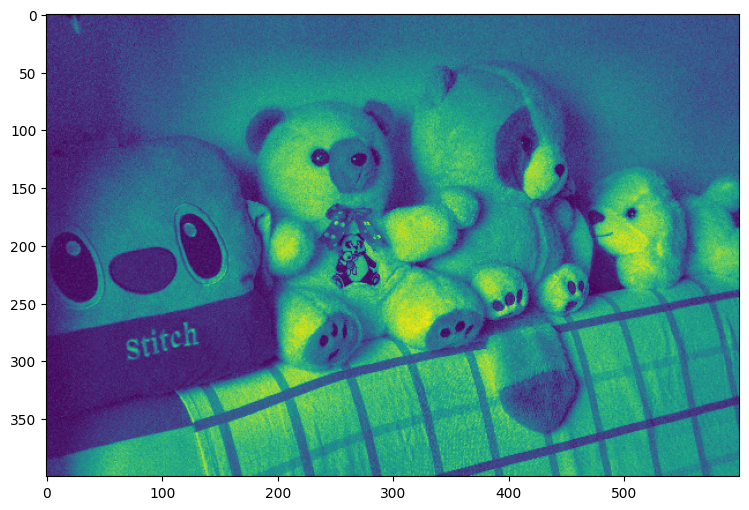

In [8]:
plt.figure(figsize=(12, 6))


# Aplicar Equalização de Histograma Global
#global_eq_image = global_histogram_equalization(gray_image)

# Aplicar Equalização de Histograma Adaptativa (CLAHE)
adaptive_eq_image = adaptive_histogram_equalization(cv2.cvtColor(data_low[0], cv2.COLOR_BGR2GRAY), 2)

plt.imshow(data_low[0])
plt.imshow(data_hight[0])
plt.imshow(adaptive_eq_image)